<a href="https://colab.research.google.com/github/kiran-pyt/LSTM-on-Stirred-Tank-Heater/blob/main/SISO_HEATER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Text(0.5, 0, 'Time (sec)')

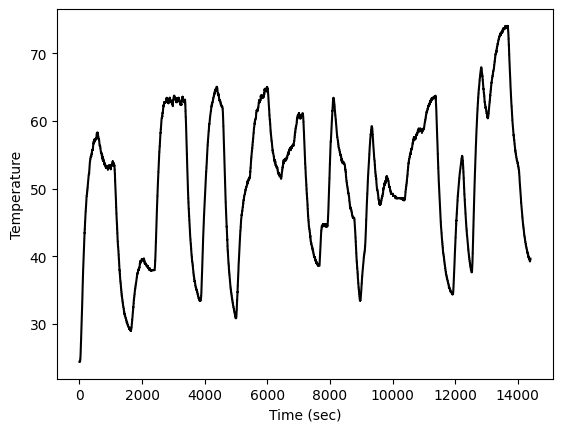

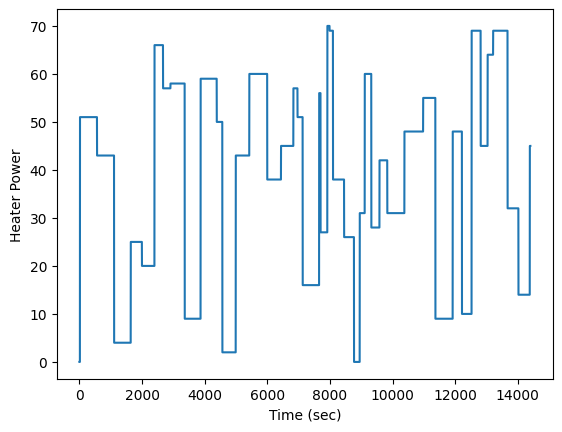

In [ ]:
# read data
df= pd.read_csv('/content/drive/MyDrive/debutnizer/TCLab_train_data.txt')
heaterPower = df[['Q1']].values
temperature = df[['T1']].values

# plot data
plt.plot(temperature, 'k')
plt.ylabel('Temperature')
plt.xlabel('Time (sec)')

plt.figure()
plt.plot(heaterPower)
plt.ylabel('Heater Power')
plt.xlabel('Time (sec)')

In [ ]:
df.head()

,Time,Q1,Q2,T1,T2
0,0.000000,0,0,24.44,0
1,1.000385,0,0,24.44,0
2,2.000896,0,0,24.44,0
3,3.002267,0,0,24.44,0
4,4.002946,0,0,24.44,0


In [ ]:
data_array = df.values

In [ ]:
# Separate features (X) and target variable (y)
X = df[['T1','Q1']].values  # All columns except the last one
y = df[['T1']].values       # Last column

# Normalize features and target variable separately
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [ ]:
# Define sequence length
seq_len = 70

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Create sequences for training data
X_train_3d = []
y_train_3d = []
for i in range(X_train.shape[0] - seq_len + 1):
    X_train_3d.append(X_train[i: i + seq_len, :])
    y_train_3d.append(y_train[i + seq_len - 1])  # Assuming you want to predict the next value after the sequence

# Create sequences for testing data
X_test_3d = []
y_test_3d = []
for i in range(X_test.shape[0] - seq_len + 1):
    X_test_3d.append(X_test[i: i + seq_len, :])
    y_test_3d.append(y_test[i + seq_len - 1])  # Assuming you want to predict the next value after the sequence

# Convert lists to numpy arrays
X_train_3d = np.array(X_train_3d)
y_train_3d = np.array(y_train_3d)
X_test_3d = np.array(X_test_3d)
y_test_3d = np.array(y_test_3d)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_3d, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_3d, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_3d, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_3d, dtype=torch.float32)
# Define batch size
batch_size = 64

# Create DataLoader for training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)

# Create DataLoader for testing data
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size)
# Define LSTM model
class MultivariateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MultivariateLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.linear(lstm_out[:, -1, :])  # Take the last hidden state
        return out

# Initialize the model
input_size =  X_train_tensor.shape[2]  # Number of features
hidden_size = 25
num_layers = 1
output_size = 1  # Assuming you're predicting a single value
model = MultivariateLSTM(input_size, hidden_size, num_layers, output_size)
# Move model to the desired device
model = model.to(device)
# Loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

MultivariateLSTM(
  (lstm): LSTM(2, 25, batch_first=True)
  (linear): Linear(in_features=25, out_features=1, bias=True)
)


In [ ]:
X_train_tensor.shape[2]

2

In [ ]:
num_epochs = 100
train_hist =[]
test_hist =[]
# Training loop
for epoch in range(num_epochs):
	total_loss = 0.0

	# Training
	model.train()
	for batch_X, batch_y in train_loader:
		batch_X, batch_y = batch_X.to(device), batch_y.to(device)
		predictions = model(batch_X)
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss += loss.item()
    # Calculate number of correct predictions for training accuracy



	# Calculate average training loss and accuracy
	average_loss = total_loss / len(train_loader)
	train_hist.append(average_loss)


	# Validation on test data
	model.eval()
	with torch.no_grad():
		total_test_loss = 0.0

		for batch_X_test, batch_y_test in test_loader:
			batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
			predictions_test = model(batch_X_test)
			test_loss = loss_fn(predictions_test, batch_y_test)

			total_test_loss += test_loss.item()

		# Calculate average test loss and accuracy
		average_test_loss = total_test_loss / len(test_loader)
		test_hist.append(average_test_loss)
	#if (epoch+1)%10==0:
	print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


Epoch [1/100] - Training Loss: 0.4214, Test Loss: 0.0431
Epoch [2/100] - Training Loss: 0.0102, Test Loss: 0.0018
Epoch [3/100] - Training Loss: 0.0013, Test Loss: 0.0010
Epoch [4/100] - Training Loss: 0.0009, Test Loss: 0.0008
Epoch [5/100] - Training Loss: 0.0006, Test Loss: 0.0005
Epoch [6/100] - Training Loss: 0.0004, Test Loss: 0.0004
Epoch [7/100] - Training Loss: 0.0003, Test Loss: 0.0003
Epoch [8/100] - Training Loss: 0.0002, Test Loss: 0.0002
Epoch [9/100] - Training Loss: 0.0002, Test Loss: 0.0002
Epoch [10/100] - Training Loss: 0.0001, Test Loss: 0.0001
Epoch [11/100] - Training Loss: 0.0001, Test Loss: 0.0001
Epoch [12/100] - Training Loss: 0.0001, Test Loss: 0.0001
Epoch [13/100] - Training Loss: 0.0001, Test Loss: 0.0001
Epoch [14/100] - Training Loss: 0.0001, Test Loss: 0.0001
Epoch [15/100] - Training Loss: 0.0001, Test Loss: 0.0001
Epoch [16/100] - Training Loss: 0.0001, Test Loss: 0.0000
Epoch [17/100] - Training Loss: 0.0000, Test Loss: 0.0001
Epoch [18/100] - Traini

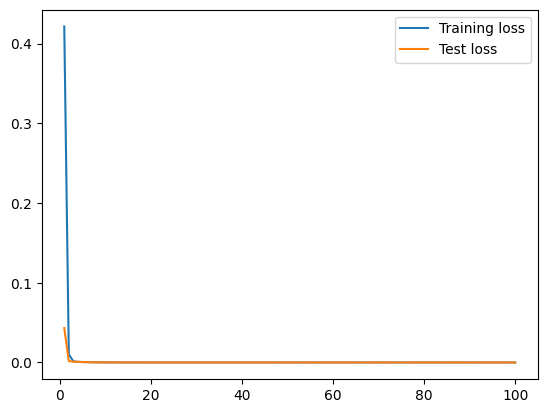

In [ ]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

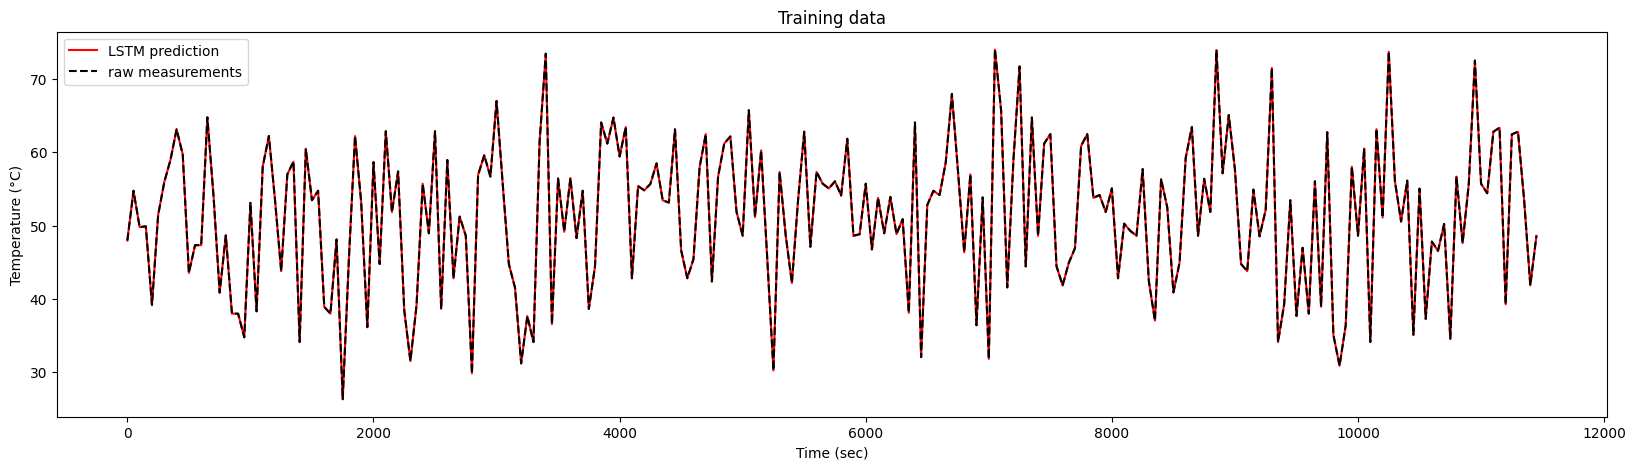

In [ ]:
import torch
import torch.nn as nn

# Assuming you have already trained your PyTorch model and have the X_train_sequence tensor ready

# Check fit on training data
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    y_train_sequence_pred = model(X_train_tensor)
    y_measured = scaler_y.inverse_transform(y_train_tensor.numpy())  # Assuming y_scaler is a scaler object
    y_pred = scaler_y .inverse_transform(y_train_sequence_pred.numpy())




# Define the number of data points to plot
n = 50 # Adjust this value as needed

# Create an array of indices to select every nth data point
indices = np.arange(0, len(y_pred), n)

# Plot a subset of data points
plt.figure(figsize=(20,5))
plt.plot(indices, y_pred[indices], 'r-', label='LSTM prediction')
plt.plot(indices, y_measured[indices], 'k--', label='raw measurements')
plt.ylabel('Temperature (°C)')
plt.xlabel('Time (sec)')
plt.legend()
plt.title('Training data')
plt.show()



In [ ]:
# Assuming seq_len is defined somewhere in your code
seq_len = 10  # Adjust this according to your requirements

data_test = pd.read_csv('/content/drive/MyDrive/debutnizer/TCLab_test_data.txt')
X_test = data_test[['T1','Q1']].values
y_test = data_test[['T1']].values
scaler_X_t = StandardScaler()
scaler_y_t = StandardScaler()

X_scaled = scaler_X_t.fit_transform(X_test)  # Corrected scaler name
y_scaled = scaler_y_t.fit_transform(y_test.reshape(-1, 1))  # Corrected scaler name

# Create sequences for validation data
X_test_3d_V = []
y_test_3d_V = []
for i in range(X_scaled.shape[0] - seq_len + 1):
    X_test_3d_V.append(X_scaled[i: i + seq_len, :])
    y_test_3d_V.append(y_scaled[i + seq_len - 1])  # Assuming you want to predict the next value after the sequence

X_test_3d_V = np.array(X_test_3d_V)
y_test_3d_V = np.array(y_test_3d_V)
X_test_tensor_V = torch.tensor(X_test_3d_V, dtype=torch.float32)
y_test_tensor_V = torch.tensor(y_test_3d_V, dtype=torch.float32)
y_test_tensor_V=scaler_y_t.inverse_transform(y_test_tensor_V.numpy())
# Check fit on training data
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    y_train_sequence_pred = model(X_test_tensor_V)

    y_pred_seq = scaler_y_t.inverse_transform(y_train_sequence_pred.numpy())  # Corrected scaler name


In [ ]:
X_test_tensor_V.shape

torch.Size([832, 10, 2])

In [ ]:
y_test_tensor_V.shape

(832, 1)

In [ ]:
y_pred_seq.shape

(832, 1)

In [ ]:
y_test_tensor_V

array([[16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.06    ],
       [16.29    ],
       [16.390001],
       [16.390001],
       [16.390001],
       [16.55    ],
       [16.710001],
       [16.710001],
       [16.77    ],
       [17.      ],
       [17.03    ],
       [17.03    ],
       [17.35    ],
       [17.35    ],
       [17.35    ],
       [17.64    ],
       [17.68    ],
       [17.77    ],
       [18.      ],
       [18.      ],


In [ ]:
y_pred_seq

array([[15.194649],
       [15.194649],
       [15.194649],
       [15.194649],
       [15.194649],
       [15.194649],
       [15.194649],
       [15.194649],
       [15.194649],
       [15.194649],
       [15.194649],
       [15.194649],
       [15.194649],
       [15.194649],
       [15.194649],
       [15.194649],
       [15.194649],
       [15.194649],
       [15.194649],
       [15.194649],
       [15.194649],
       [15.299202],
       [15.272289],
       [15.310364],
       [15.344551],
       [15.373924],
       [15.395237],
       [15.40678 ],
       [15.407297],
       [15.394321],
       [15.368517],
       [15.600168],
       [15.70237 ],
       [15.706039],
       [15.709227],
       [15.872887],
       [16.037264],
       [16.042027],
       [16.107279],
       [16.343056],
       [16.377998],
       [16.383322],
       [16.710367],
       [16.715229],
       [16.721466],
       [17.018559],
       [17.063688],
       [17.160755],
       [17.398188],
       [17.403608],


In [ ]:
y_test.shape

(841, 1)

In [ ]:
y_measured


array([[47.97    ],
       [30.890001],
       [62.83    ],
       ...,
       [51.19    ],
       [53.13    ],
       [48.61    ]], dtype=float32)

In [ ]:
y_pred

array([[47.95493 ],
       [30.868053],
       [62.824818],
       ...,
       [51.16971 ],
       [53.111282],
       [48.59424 ]], dtype=float32)

In [ ]:
import pandas as pd

# Assuming y_measured and y_pred are numpy arrays

# Convert y_measured and y_pred to pandas DataFrames
df_measured = pd.DataFrame(y_measured, columns=['Measured Temperature (°C)'])
df_pred = pd.DataFrame(y_pred, columns=['Predicted Temperature (°C)'])

# Concatenate the DataFrames
df_combined = pd.concat([df_measured, df_pred], axis=1)

# Define the file path
file_path = '/content/drive/MyDrive/debutnizer/predictions.csv'

# Save the combined DataFrame to the specified file path
df_combined.to_csv(file_path, index=False)